In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import joblib

In [2]:
# Чтение данных 
df = pd.read_csv('cars.csv', sep=';', encoding='utf-16-le')

### Разведочный анализ

In [32]:
# Вывод нескольких строк для проверки
df.sample(5)

,brand,currency,description,model,price,url,year,Город,Коробка передач,Кузов,"Объем двигателя, л",Привод,Растаможен,Руль,Цвет,Пробег,Наличие,VIN
105213,Toyota,₸,"рейлинги, литые диски, тонировка , велюр , а...",Camry,3200000,https://kolesa.kz/a/show/95789287,2002,Алматы,автомат,седан,2.4 (бензин),передний привод,Да,слева,серый,182 000 км,NaN,NaN
57925,Toyota,₸,NaN,Land Cruiser,3600000,https://kolesa.kz/a/show/95638284,1996,Актобе,механика,внедорожник,4.5 (дизель),NaN,Нет,слева,черный металлик,NaN,NaN,NaN
90984,Chevrolet,₸,"литые диски, тонировка , хрустальная оптика ,...",Cruze,3200000,https://kolesa.kz/a/show/95748872,2014,Усть-Каменогорск,автомат,седан,1.8 (бензин),передний привод,Да,слева,белый,114 000 км,NaN,NaN
102535,Toyota,₸,"литые диски, панорамная крыша, тонировка, люк ...",Camry,2700000,https://kolesa.kz/a/show/95781518,1998,Нур-Султан (Астана),автомат,седан,2.2 (бензин),передний привод,Да,слева,белый,179 938 км,NaN,NaN
63548,Toyota,₸,"литые диски, тонировка, ветровики , обогрев з...",Camry,3200000,https://kolesa.kz/a/show/95658435,2003,Алматы,автомат,седан,2.4 (бензин),передний привод,Да,слева,серебристый,NaN,NaN,NaN


In [33]:
df.describe()

,price,year
count,1.085360e+05,108536.000000
mean,3.627690e+06,2003.358231
std,5.502069e+06,8.957116
min,5.500000e+02,1913.000000
25%,1.000000e+06,1996.000000
50%,2.000000e+06,2004.000000
75%,4.000000e+06,2011.000000
max,2.600000e+08,2019.000000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108536 entries, 0 to 108535
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   brand               108536 non-null  object
 1   currency            108536 non-null  object
 2   description         103280 non-null  object
 3   model               108495 non-null  object
 4   price               108536 non-null  int64 
 5   url                 108536 non-null  object
 6   year                108536 non-null  int64 
 7   Город               108536 non-null  object
 8   Коробка передач     108536 non-null  object
 9   Кузов               108536 non-null  object
 10  Объем двигателя, л  108508 non-null  object
 11  Привод              94814 non-null   object
 12  Растаможен          108536 non-null  object
 13  Руль                108508 non-null  object
 14  Цвет                97862 non-null   object
 15  Пробег              64816 non-null   object
 16  На

Объём двигателя представляет собой строку из значения объема и типа топлива. Можно разделить на два признака: engine volume и fuel

Пробег - строка, переводим в число

In [3]:
df[['engine volume', 'fuel']] = df['Объем двигателя, л'].str.extract(r'(\d+\.\d+|\d+) \((\w+-?\w*)\)')

df['engine volume'] = df['engine volume'].astype(float)

In [4]:
df['mileage'] = df['Пробег'].str.replace(' ', '').str.extract('(\d+)', expand=False).astype(float)

#mean_mileage_by_year = df.groupby('year')['mileage'].mean()
#df['mileage'] = df.apply(lambda row: mean_mileage_by_year[row['year']] if pd.isna(row['mileage']) else row['mileage'], axis=1)
df['mileage'].fillna(0, inplace=True)

In [5]:
# удаляем записи с пропусками, так как их не много
df.dropna(subset=['model','Руль','engine volume','fuel'], inplace=True)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108439 entries, 0 to 108535
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brand               108439 non-null  object 
 1   currency            108439 non-null  object 
 2   description         103190 non-null  object 
 3   model               108439 non-null  object 
 4   price               108439 non-null  int64  
 5   url                 108439 non-null  object 
 6   year                108439 non-null  int64  
 7   Город               108439 non-null  object 
 8   Коробка передач     108439 non-null  object 
 9   Кузов               108439 non-null  object 
 10  Объем двигателя, л  108439 non-null  object 
 11  Привод              94739 non-null   object 
 12  Растаможен          108439 non-null  object 
 13  Руль                108439 non-null  object 
 14  Цвет                97782 non-null   object 
 15  Пробег              64777 non-null   ob

In [6]:
quantitative_columns = df[['price', 'year', 'engine volume', 'mileage']]

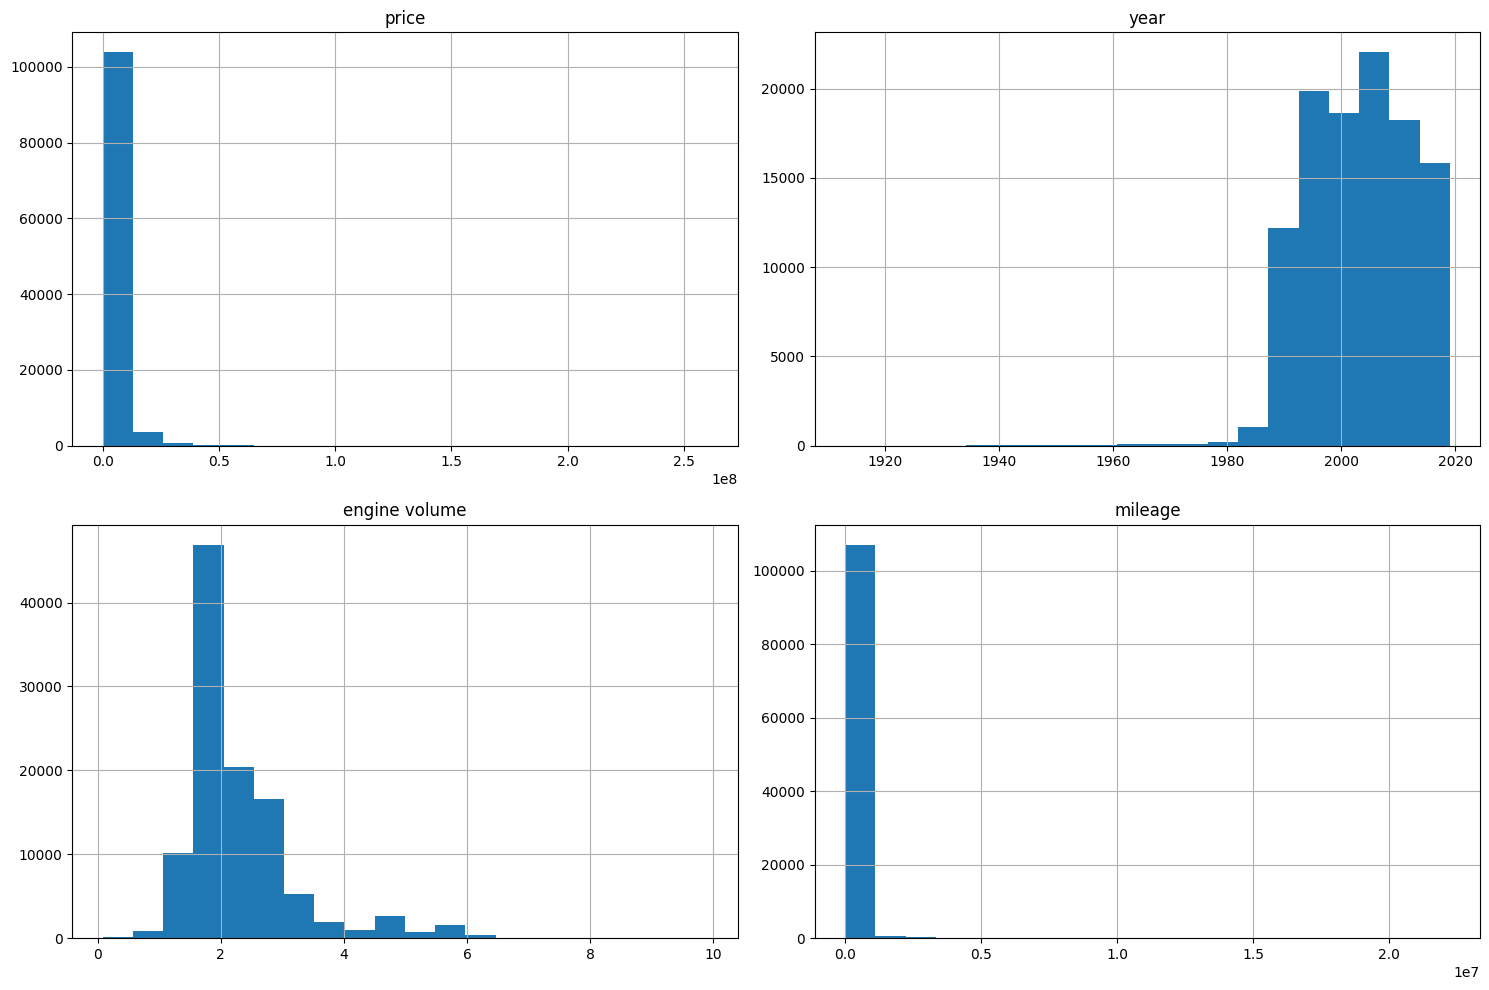

In [7]:
quantitative_columns.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

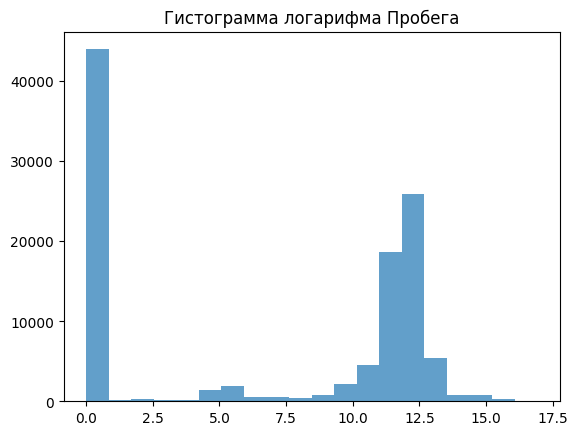

In [8]:
# Применение логарифмической трансформации к пробегу для приведения к более нормальному виду
df['log_mileage'] = np.log1p(df['mileage'])

# Гистограмма после логарифмической трансформации
plt.hist(df['log_mileage'], bins=20, alpha=0.7)
plt.title('Гистограмма логарифма Пробега')
plt.show()

In [42]:
df.head()

,brand,currency,description,model,price,url,year,Город,Коробка передач,Кузов,...,Растаможен,Руль,Цвет,Пробег,Наличие,VIN,engine volume,fuel,mileage,log_mileage
0,Mercedes-Benz,₸,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,https://kolesa.kz/a/show/10235750,2008,Актау,типтроник,внедорожник,...,Да,слева,черный металлик,NaN,NaN,NaN,5.5,бензин,0.0,0.000000
1,BMW,₸,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,https://kolesa.kz/a/show/10269314,2009,Нур-Султан (Астана),автомат,кроссовер,...,Да,слева,черный,170 км,NaN,NaN,4.8,бензин,170.0,5.141664
2,Mercedes-Benz,₸,"лонг, состояние нового авто немец газ-бензин п...",S 350,7770000,https://kolesa.kz/a/show/1063798,2006,Алматы,типтроник,седан,...,Да,слева,черный,60 000 км,NaN,NaN,3.5,бензин,60000.0,11.002117
3,Mitsubishi,₸,"литые диски, тонировка, люк , хрустальная опт...",Outlander,3200000,https://kolesa.kz/a/show/10695701,2003,Семей,типтроник,кроссовер,...,Да,слева,серебристый металлик,120 000 км,NaN,NaN,2.4,бензин,120000.0,11.695255
4,Ретро-автомобили,₸,"налог уплачен, техосмотр пройден, вложений не ...","ГАЗ 21 ""Волга""",3900000,https://kolesa.kz/a/show/10852142,1970,Алматы,механика,седан,...,Да,слева,черный,1 200 км,NaN,NaN,2.4,бензин,1200.0,7.090910


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108439 entries, 0 to 108535
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brand               108439 non-null  object 
 1   currency            108439 non-null  object 
 2   description         103190 non-null  object 
 3   model               108439 non-null  object 
 4   price               108439 non-null  int64  
 5   url                 108439 non-null  object 
 6   year                108439 non-null  int64  
 7   Город               108439 non-null  object 
 8   Коробка передач     108439 non-null  object 
 9   Кузов               108439 non-null  object 
 10  Объем двигателя, л  108439 non-null  object 
 11  Привод              94739 non-null   object 
 12  Растаможен          108439 non-null  object 
 13  Руль                108439 non-null  object 
 14  Цвет                97782 non-null   object 
 15  Пробег              64777 non-null   ob

In [9]:
categorical_columns = df[['brand', 'currency', 'model', 'Город','Коробка передач','Кузов','Привод','Растаможен','Руль','Цвет','Наличие','fuel']]

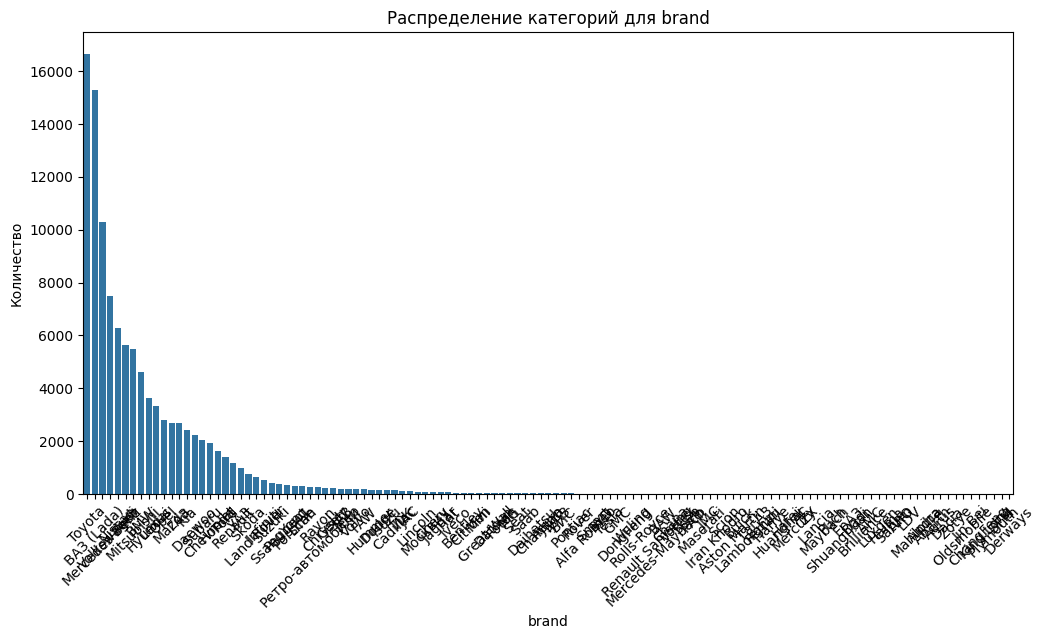

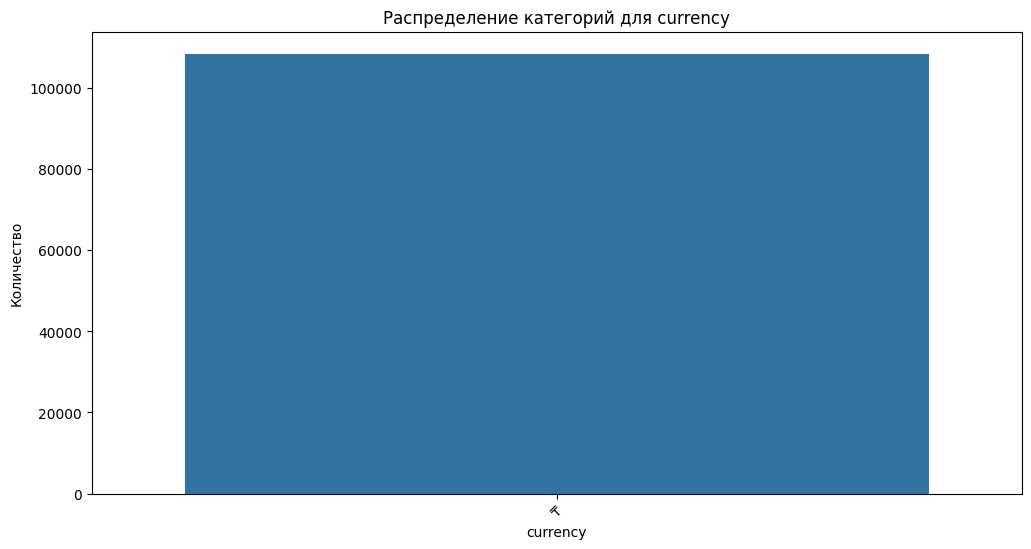

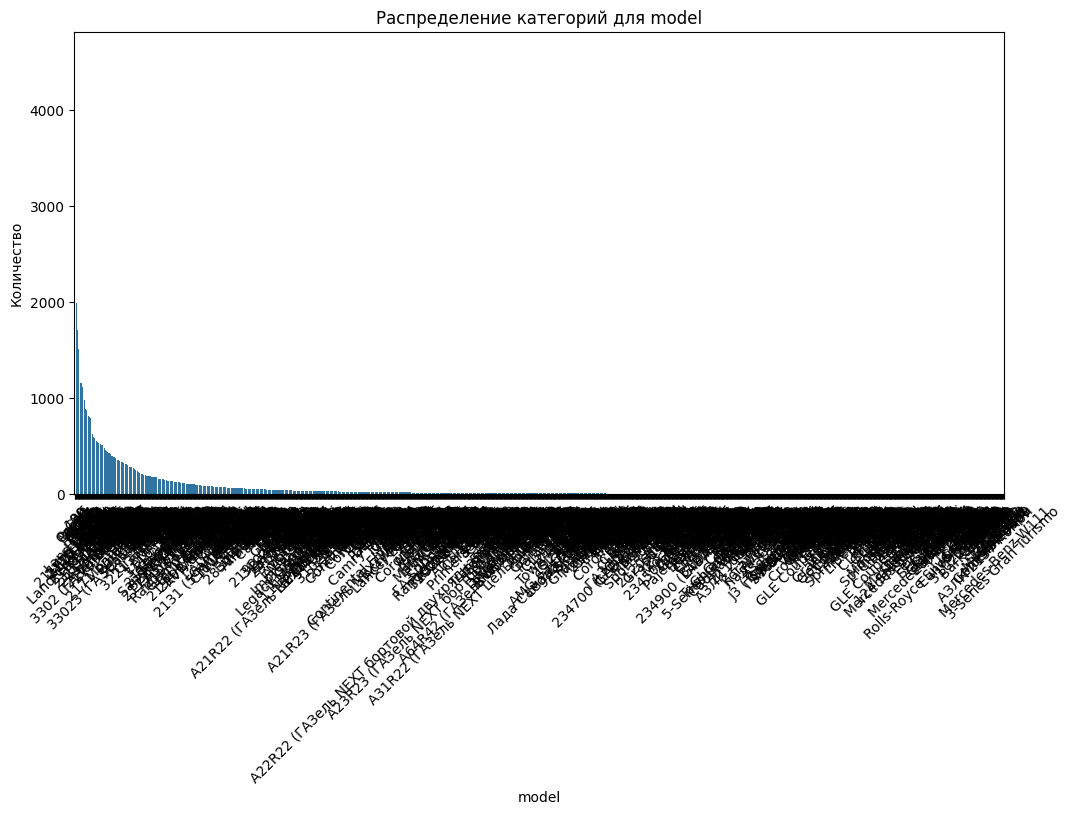

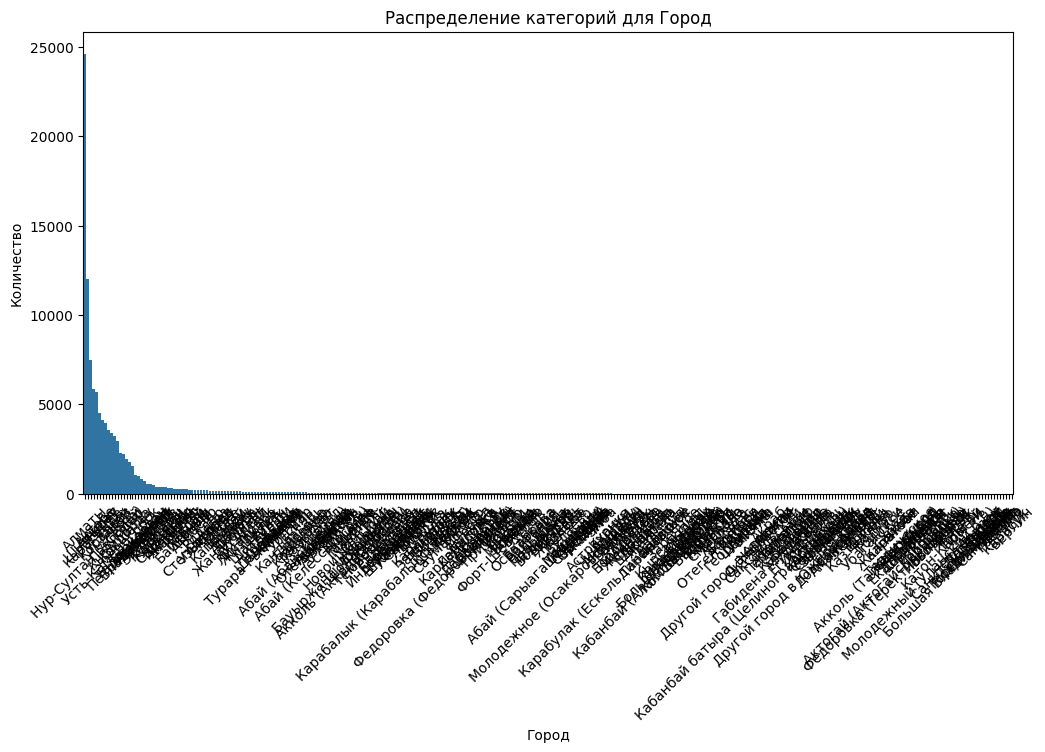

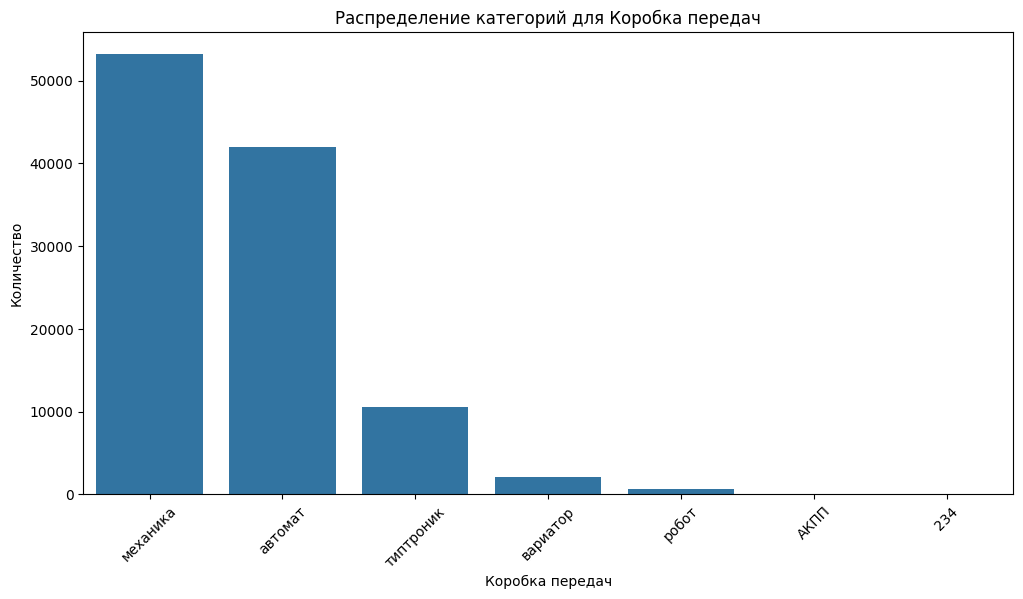

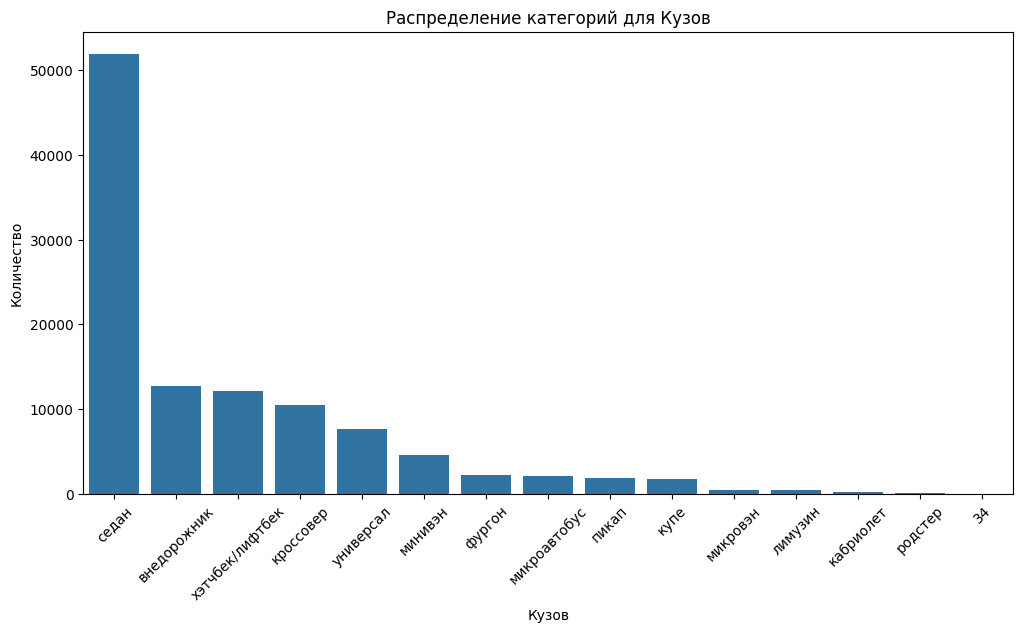

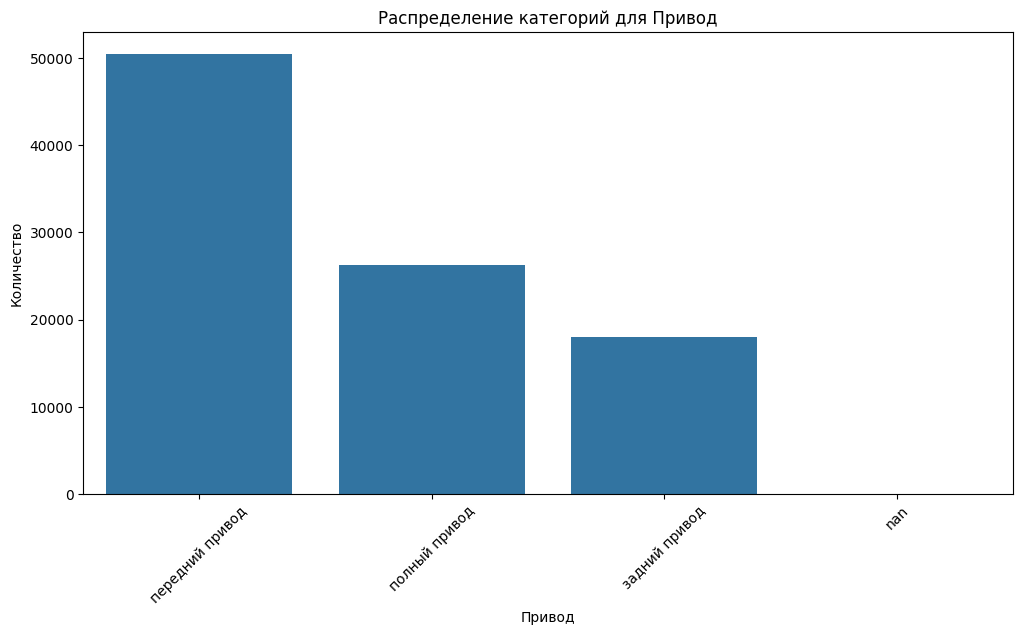

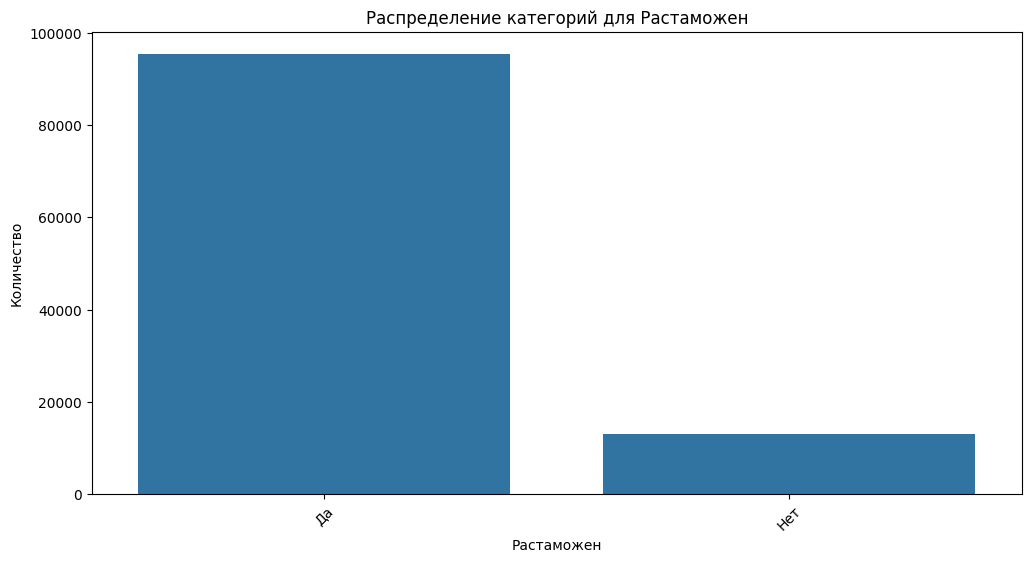

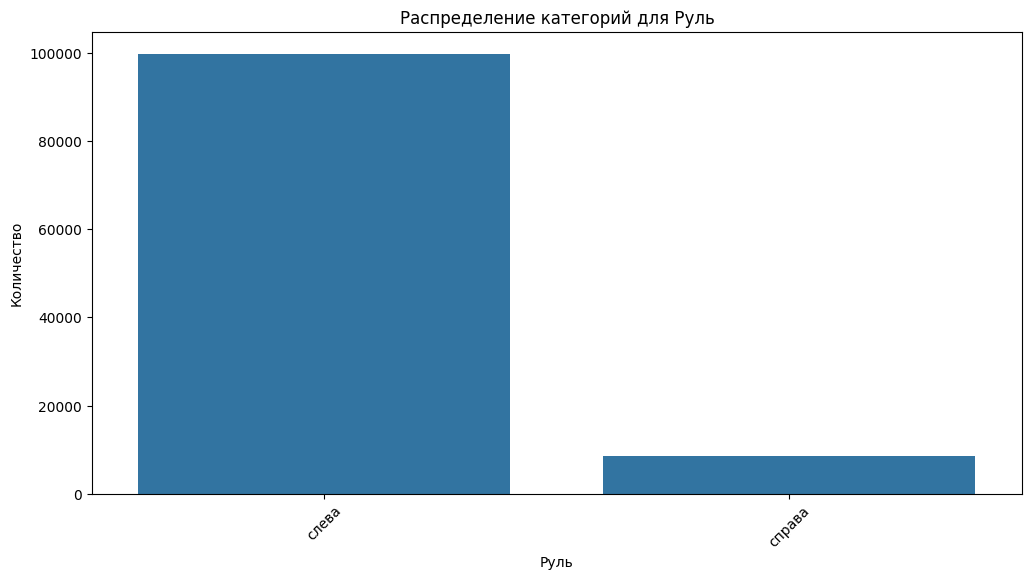

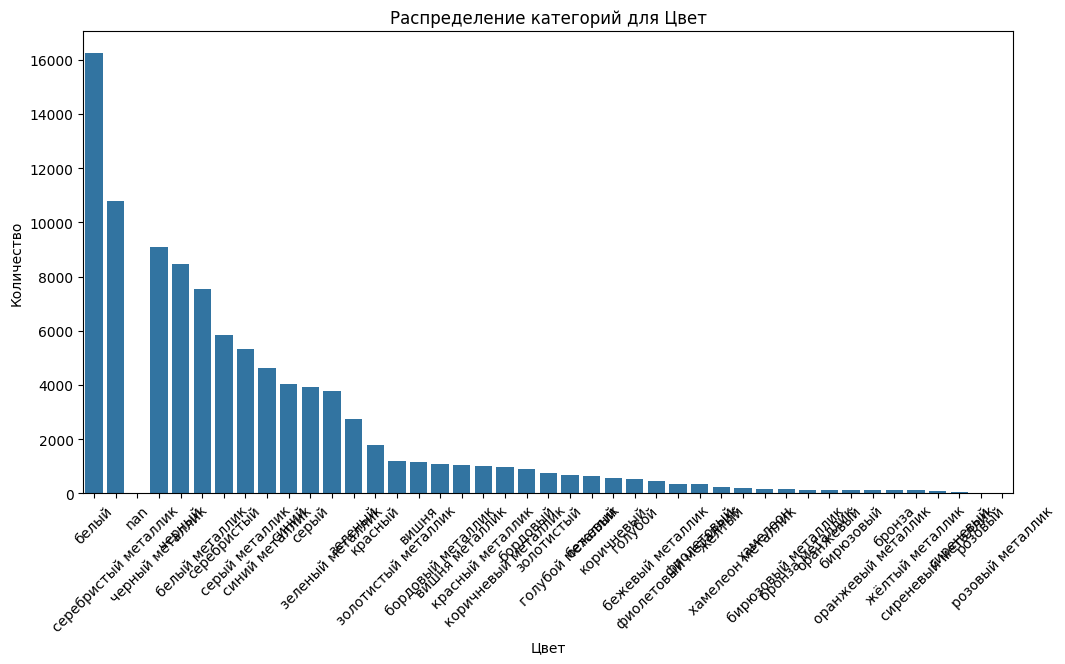

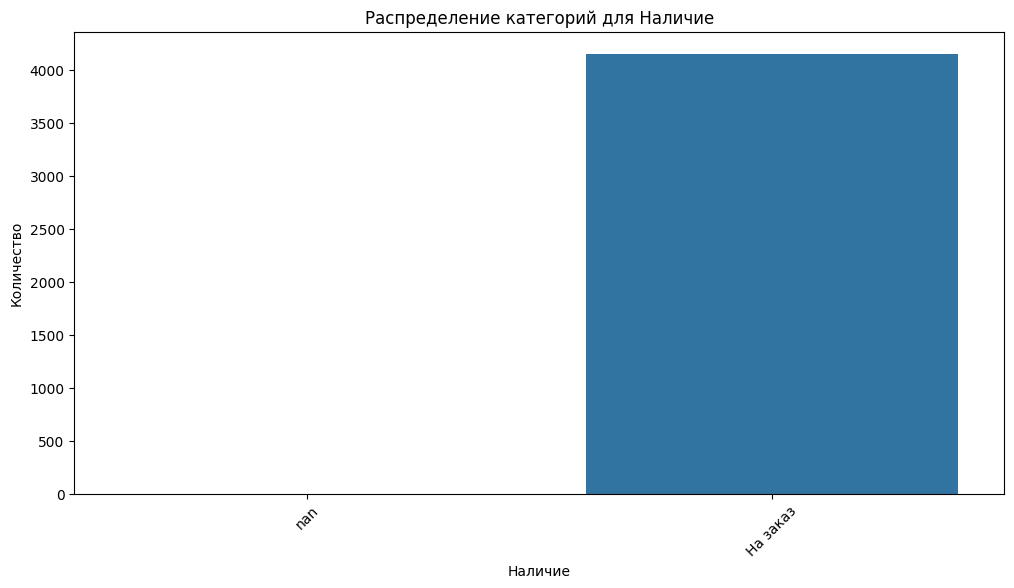

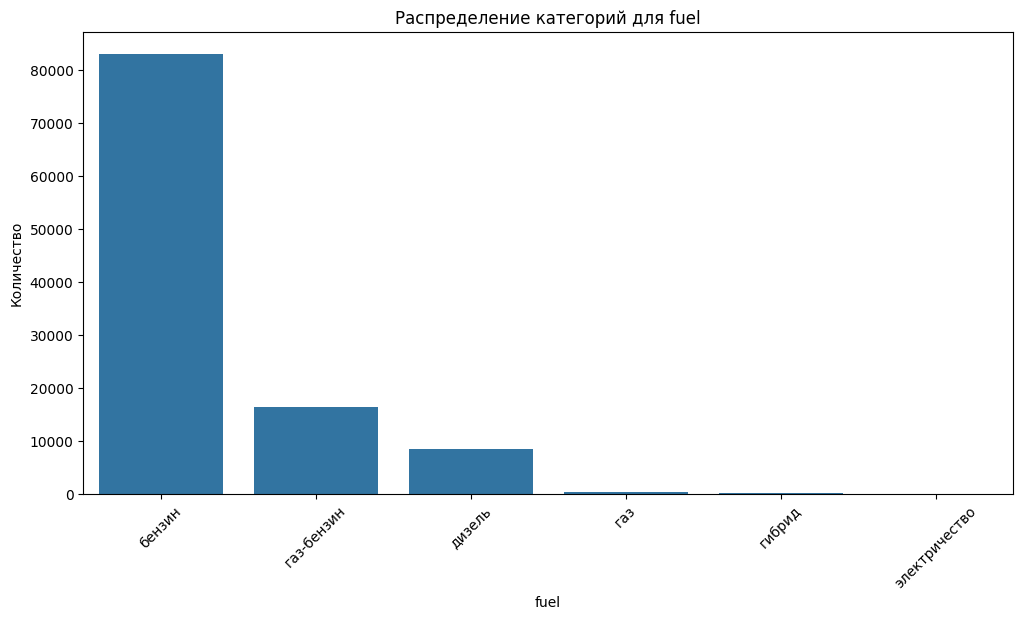

In [158]:
for column in categorical_columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=column, order=df[column].value_counts(dropna=False).index)
    plt.title(f'Распределение категорий для {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.show()

In [46]:
# Вывод количества уникальных категорий для каждой категориальной переменной
for column in categorical_columns:
    unique_categories = df[column].nunique()
    print(f'Кардинальность столбца {column}: {unique_categories}')

Кардинальность столбца brand: 121
Кардинальность столбца currency: 1
Кардинальность столбца model: 1633
Кардинальность столбца Город: 311
Кардинальность столбца Коробка передач: 7
Кардинальность столбца Кузов: 15
Кардинальность столбца Привод: 3
Кардинальность столбца Растаможен: 2
Кардинальность столбца Руль: 2
Кардинальность столбца Цвет: 42
Кардинальность столбца Наличие: 1
Кардинальность столбца fuel: 6


Валюта везде одинаковая - убираем.

В коробке передач АКПП и автомат одно и то же, заменяем АКПП на автомат.

Признак Растаможен кодируем 0 и 1.

Руль кодируем (слева - 1, справа - 0).

Наличие кодируем (На заказ - 1, остальное - 0).

Цвет состоит из цвета и свойства металлик (вариативно). Разделяем на два признака: colour и metallic (1 - металлик, 0 - нет)

In [10]:
df['Коробка передач'] = df['Коробка передач'].replace({'АКПП': 'автомат'})

In [11]:
df['customs_clearance'] = df['Растаможен'].str.lower().map({'да': 1, 'нет': 0})

In [12]:
df['left_hand_drive'] = df['Руль'].str.lower().map({'слева': 1, 'справа': 0})

In [13]:
df['Order'] = df['Наличие'].apply(lambda x: 1 if x == 'На заказ' else 0)

In [14]:
# Создаем столбец "металлик"
df['metallic'] = df['Цвет'].apply(lambda x: 1 if pd.notna(x) and 'металлик' in x.lower() else (0 if pd.notna(x) else np.nan))
df['metallic'] = df['metallic'].astype('Int64') 

# Заменяем "металлик" в столбце "Цвет" и убираем лишние пробелы
df['colour'] = df['Цвет'].apply(lambda x: x.replace('металлик', '').strip().capitalize() if pd.notna(x) else np.nan)

In [52]:
df.sample(5)

,brand,currency,description,model,price,url,year,Город,Коробка передач,Кузов,...,VIN,engine volume,fuel,mileage,log_mileage,customs_clearance,left_hand_drive,Order,metallic,colour
74410,Mazda,₸,Продам машину! Срочно позвонить 87761391233,626,350000,https://kolesa.kz/a/show/95697006,1984,Нур-Султан (Астана),механика,седан,...,NaN,1.8,бензин,0.0,0.000000,1,0,0,0,Серый
77342,Mazda,₸,"полный электропакет, ГУР",929,350000,https://kolesa.kz/a/show/95706987,1986,Алматы,механика,седан,...,NaN,2.0,бензин,0.0,0.000000,1,1,0,<NA>,NaN
79301,Toyota,₸,"литые диски, тонировка, ветровики, рейлинги, б...",Avensis Verso,2300000,https://kolesa.kz/a/show/95712893,2002,Алматы,механика,минивэн,...,NaN,2.0,дизель,300000.0,12.611541,1,1,0,1,Серебристый
79482,Chevrolet,₸,"ветровики, литые диски, тонировка , обогрев з...",Niva,2900000,https://kolesa.kz/a/show/95713456,2014,Нур-Султан (Астана),механика,внедорожник,...,NaN,1.7,бензин,56000.0,10.933125,1,1,0,1,Серебристый
70370,Toyota,₸,NaN,Corolla,99999,https://kolesa.kz/a/show/95681672,1991,Алматы,механика,хэтчбек/лифтбек,...,NaN,1.6,бензин,0.0,0.000000,1,1,0,<NA>,NaN


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108439 entries, 0 to 108535
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brand               108439 non-null  object 
 1   currency            108439 non-null  object 
 2   description         103190 non-null  object 
 3   model               108439 non-null  object 
 4   price               108439 non-null  int64  
 5   url                 108439 non-null  object 
 6   year                108439 non-null  int64  
 7   Город               108439 non-null  object 
 8   Коробка передач     108439 non-null  object 
 9   Кузов               108439 non-null  object 
 10  Объем двигателя, л  108439 non-null  object 
 11  Привод              94739 non-null   object 
 12  Растаможен          108439 non-null  object 
 13  Руль                108439 non-null  object 
 14  Цвет                97782 non-null   object 
 15  Пробег              64777 non-null   ob

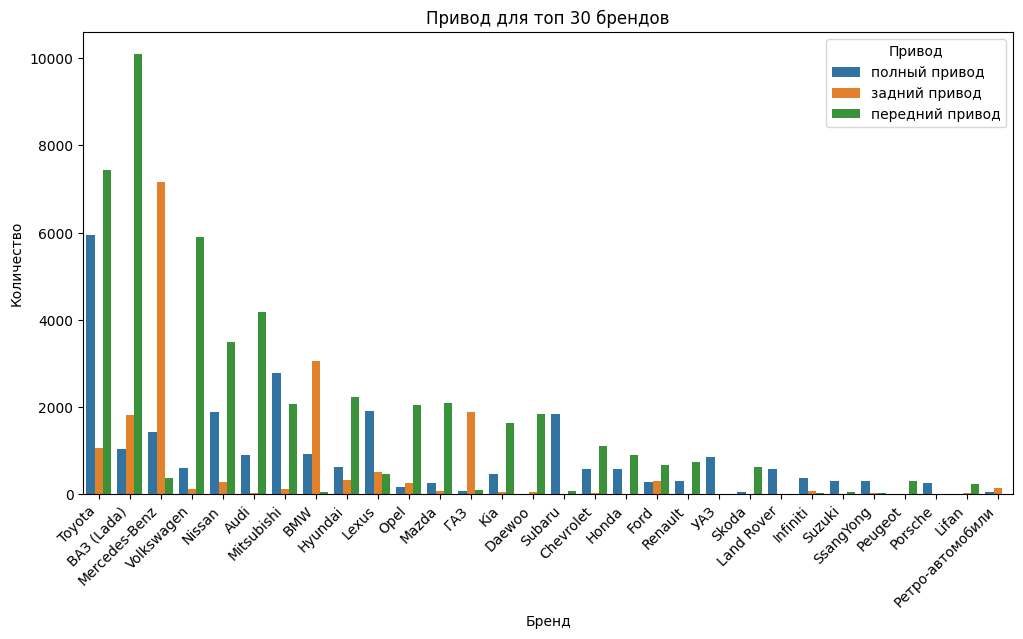

In [54]:
top_brands = df['brand'].value_counts().head(30).index

# Фильтруем датафрейм по топовым брендам
df_top_brands = df[df['brand'].isin(top_brands)]

# Строим график
plt.figure(figsize=(12, 6))
sns.countplot(x='brand', hue='Привод', data=df_top_brands, order=top_brands)
plt.title('Привод для топ 30 брендов')
plt.xlabel('Бренд')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')  # Поворачиваем подписи оси x для удобства
plt.legend(title='Привод')
plt.show()

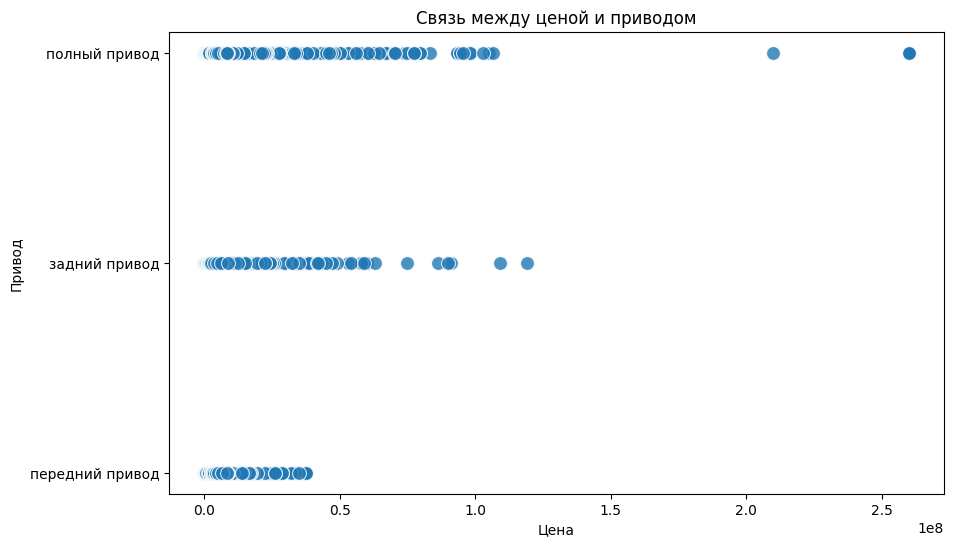

In [55]:
# Строим точечный график
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='Привод', data=df, marker='o', s=100, alpha=0.8)
plt.title('Связь между ценой и приводом')
plt.xlabel('Цена')
plt.ylabel('Привод')
plt.show()

Привод не зависит от бренда и на цену не влияет сильно. Пропуски привода заполняем модой.

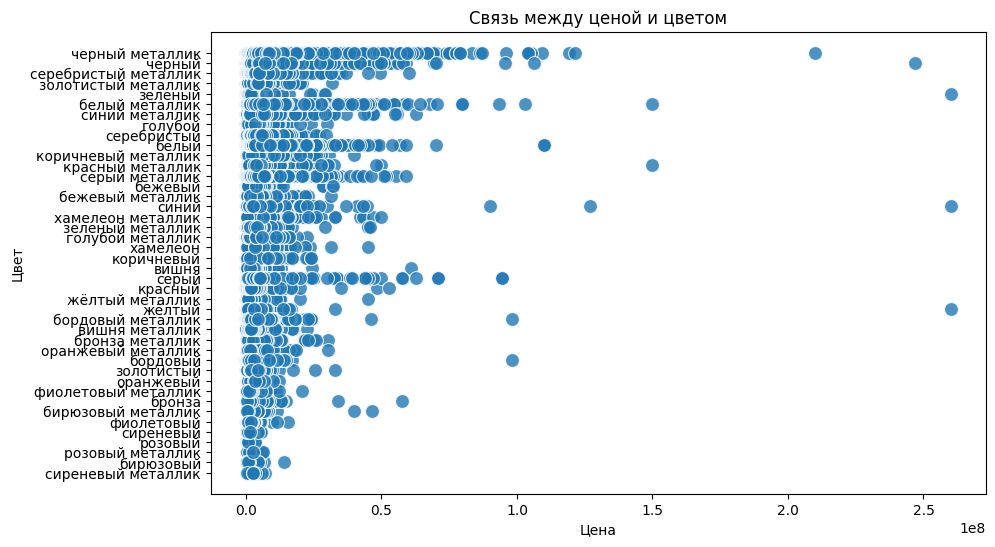

In [59]:
# Строим точечный график
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='Цвет', data=df, marker='o', s=100, alpha=0.8)
plt.title('Связь между ценой и цветом')
plt.xlabel('Цена')
plt.ylabel('Цвет')
plt.show()

Цвет не сильно коррелирует с ценой. Пропуски заполняем модой.

In [15]:
df['wheel_drive'] = df['Привод'].fillna(df['Привод'].mode()[0])

In [16]:
df['colour'].fillna(df['colour'].mode()[0], inplace=True)

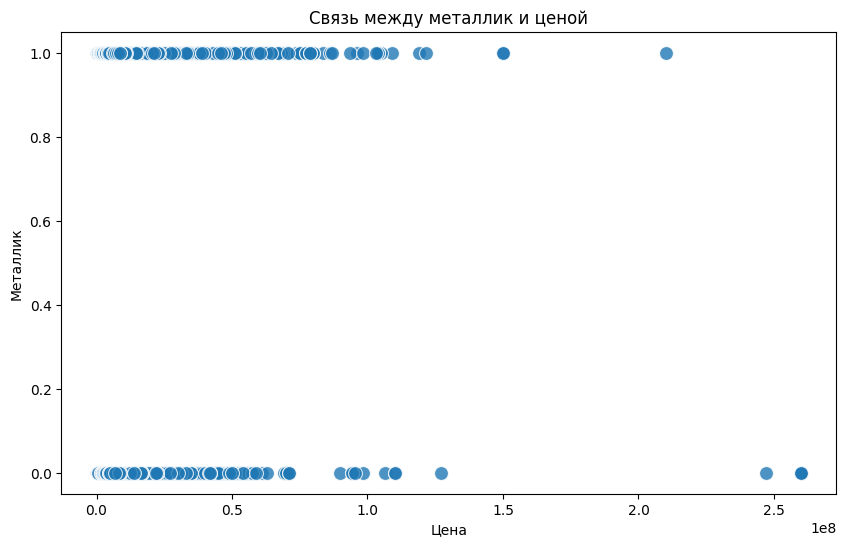

In [62]:
# Строим точечный график
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='metallic', data=df, marker='o', s=100, alpha=0.8)
plt.title('Связь между металлик и ценой')
plt.xlabel('Цена')
plt.ylabel('Металлик')
plt.show()

Зависимости между металлик и ценой нет. Запоняем случайно пропуски 0 или 1.

In [17]:
df['metallic'] = df['metallic'].apply(lambda x: np.random.choice([0, 1]) if pd.isna(x) else x)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108439 entries, 0 to 108535
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brand               108439 non-null  object 
 1   currency            108439 non-null  object 
 2   description         103190 non-null  object 
 3   model               108439 non-null  object 
 4   price               108439 non-null  int64  
 5   url                 108439 non-null  object 
 6   year                108439 non-null  int64  
 7   Город               108439 non-null  object 
 8   Коробка передач     108439 non-null  object 
 9   Кузов               108439 non-null  object 
 10  Объем двигателя, л  108439 non-null  object 
 11  Привод              94739 non-null   object 
 12  Растаможен          108439 non-null  object 
 13  Руль                108439 non-null  object 
 14  Цвет                97782 non-null   object 
 15  Пробег              64777 non-null   ob

C:\Users\Anna\AppData\Local\Temp\ipykernel_14484\825087007.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_cars.index, y=top20_cars.values, palette='hot', ax=ax)


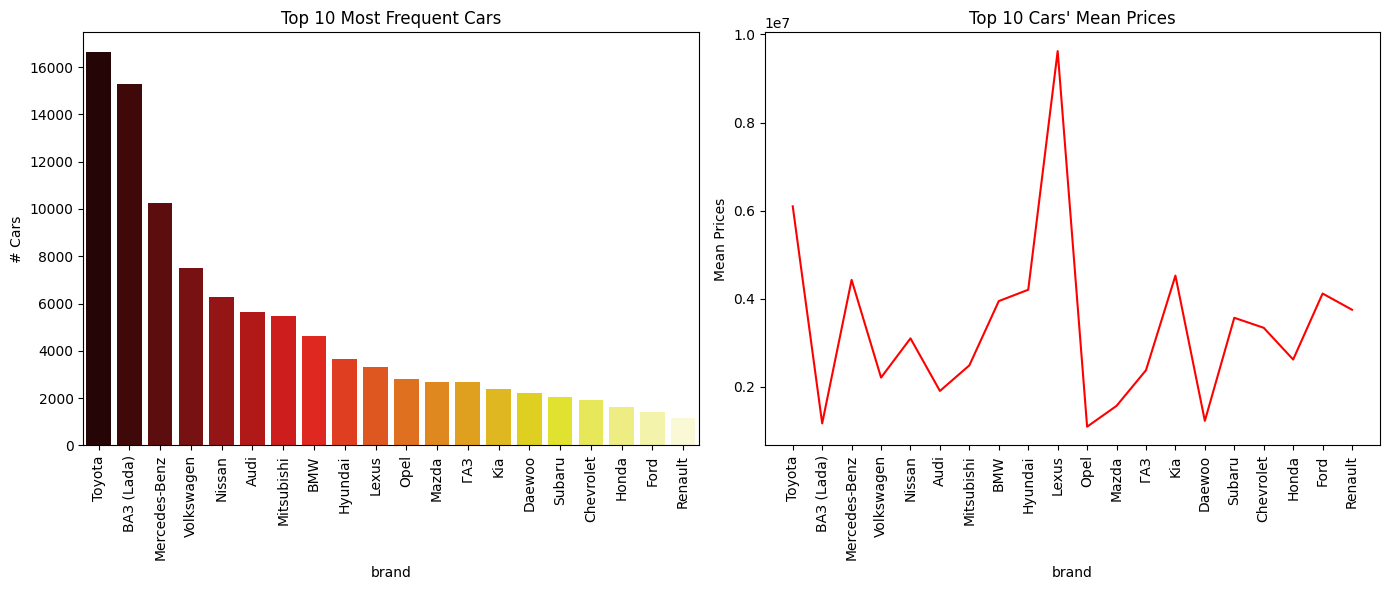

In [65]:
top20_cars = df['brand'].value_counts().sort_values(ascending=False)[:20]
top20_mean_prices = [df[df['brand'] == i]['price'].mean() for i in list(top20_cars.index)]

fig = plt.figure(figsize=(14, 6))

# Subplot 1 - Barplot for the number of cars
ax = fig.add_subplot(121)
sns.barplot(x=top20_cars.index, y=top20_cars.values, palette='hot', ax=ax)
plt.xticks(rotation=90)
plt.ylabel('# Cars')
plt.title('Top 10 Most Frequent Cars')

# Subplot 2 - Lineplot for mean prices
ax2 = fig.add_subplot(122)
sns.lineplot(x=top20_cars.index, y=top20_mean_prices, color='r', ax=ax2)
plt.xticks(rotation=90)
plt.ylabel('Mean Prices')
plt.title("Top 10 Cars' Mean Prices")

plt.tight_layout()
plt.show()

Цена зависит от бренда. Особенно видно на очень дорогих марках автомобилей. Оставляем этот признак.

C:\Users\Anna\AppData\Local\Temp\ipykernel_14484\2770637053.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_cars.index, y=top20_cars.values, palette='hot', ax=ax)


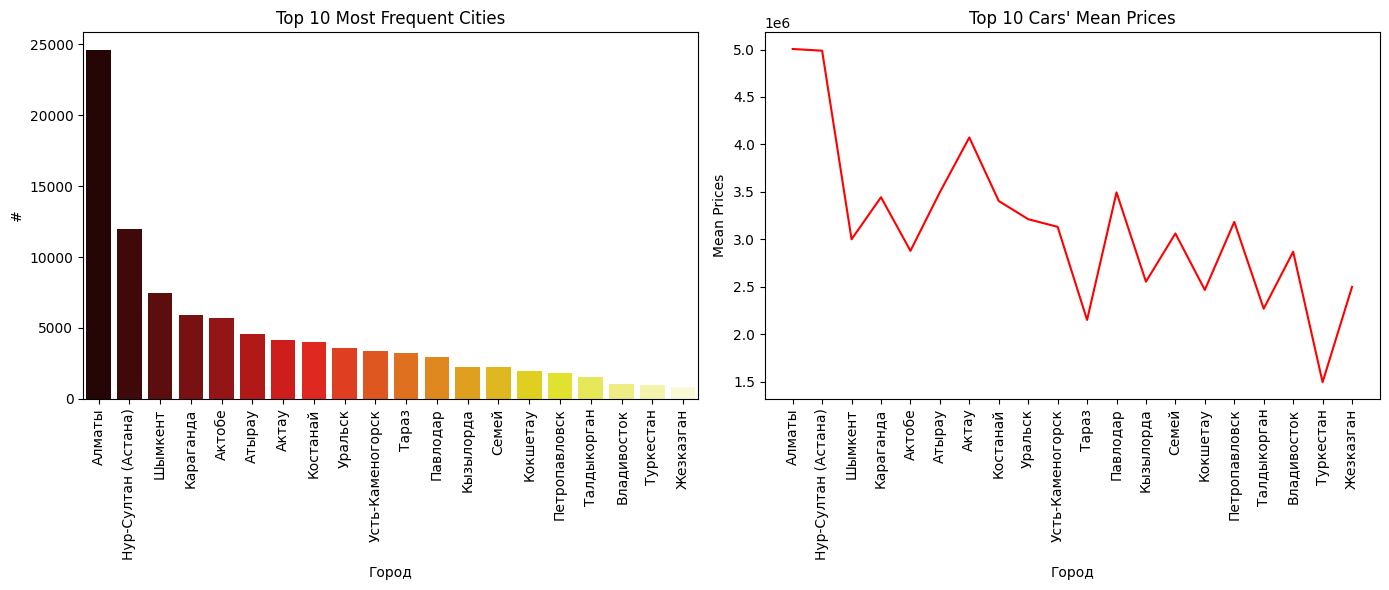

In [66]:
top20_cars = df['Город'].value_counts().sort_values(ascending=False)[:20]
top20_mean_prices = [df[df['Город'] == i]['price'].mean() for i in list(top20_cars.index)]

fig = plt.figure(figsize=(14, 6))

# Subplot 1 - Barplot for the number of cars
ax = fig.add_subplot(121)
sns.barplot(x=top20_cars.index, y=top20_cars.values, palette='hot', ax=ax)
plt.xticks(rotation=90)
plt.ylabel('#')
plt.title('Top 10 Most Frequent Cities')

# Subplot 2 - Lineplot for mean prices
ax2 = fig.add_subplot(122)
sns.lineplot(x=top20_cars.index, y=top20_mean_prices, color='r', ax=ax2)
plt.xticks(rotation=90)
plt.ylabel('Mean Prices')
plt.title("Top 10 Cars' Mean Prices")

plt.tight_layout()
plt.show()

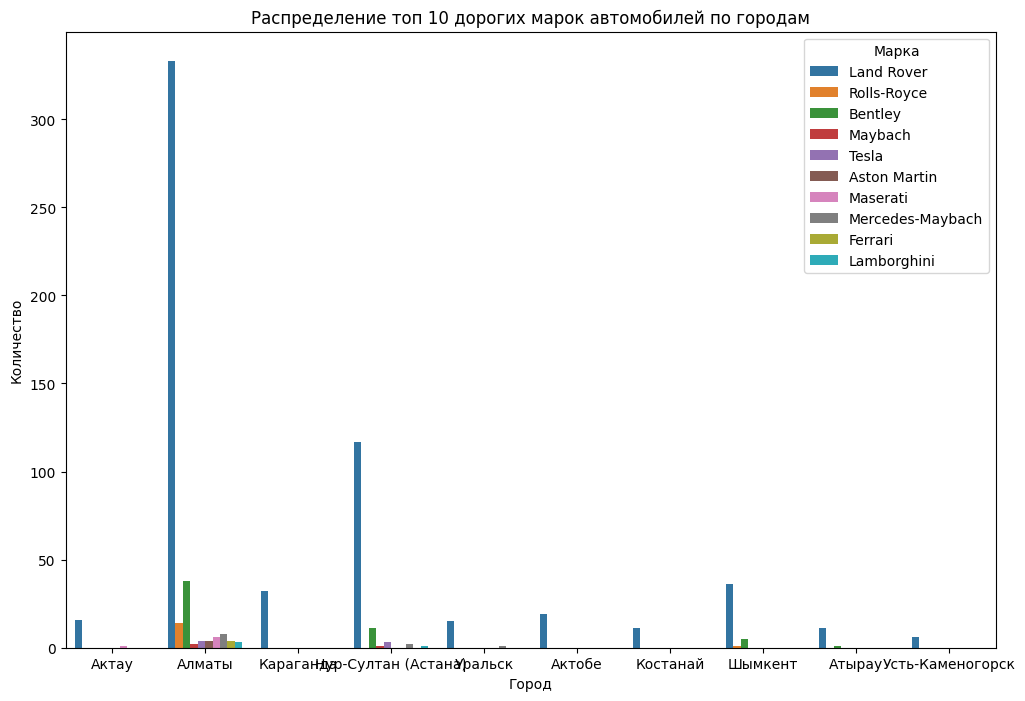

In [67]:
top_brands = df.groupby('brand')['price'].mean().sort_values(ascending=False).head(10).index
top_cities = df['Город'].value_counts().head(10).index

df_top10 = df[df['brand'].isin(top_brands)]
df_top10_and_top_cities = df_top10[df_top10['Город'].isin(top_cities)]


plt.figure(figsize=(12, 8))
sns.countplot(data=df_top10_and_top_cities, x='Город', hue='brand')
plt.title('Распределение топ 10 дорогих марок автомобилей по городам')
plt.xlabel('Город')
plt.ylabel('Количество')
plt.legend(title='Марка')
plt.show()

Убираем город из признаков. Город коррелирует с ценой, только по причине наличия в более больших городах более дорогих марок.

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108439 entries, 0 to 108535
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brand               108439 non-null  object 
 1   currency            108439 non-null  object 
 2   description         103190 non-null  object 
 3   model               108439 non-null  object 
 4   price               108439 non-null  int64  
 5   url                 108439 non-null  object 
 6   year                108439 non-null  int64  
 7   Город               108439 non-null  object 
 8   Коробка передач     108439 non-null  object 
 9   Кузов               108439 non-null  object 
 10  Объем двигателя, л  108439 non-null  object 
 11  Привод              94739 non-null   object 
 12  Растаможен          108439 non-null  object 
 13  Руль                108439 non-null  object 
 14  Цвет                97782 non-null   object 
 15  Пробег              64777 non-null   ob

In [18]:
selected_columns = ['brand','description','model', 'Коробка передач','price','year','Кузов','engine volume','fuel','log_mileage','customs_clearance','left_hand_drive','Order','metallic','colour','wheel_drive']

# Создаем новый датафрейм, выбирая только нужные столбцы, и делаем явную копию
new_df = df[selected_columns].copy()

In [19]:
new_categorical_columns = new_df[['brand', 'model','Коробка передач','Кузов','colour','fuel','wheel_drive']]

Проверяем столбец description на наличие определённых опций, которые пользователь выбирает на сайте.

In [20]:
# Список опций
outside_options = ['Литые диски','Тонировка','Люк','Панорманая крыша','Кенгурятник','Спойлер','Обвес','Лебёдка','Ветровики','Рейлинги','Багажник','Фаркоп']
optics_options = ['Ксенон','Биксенон','Хрустальная оптика','Линзованная оптика','Дневные ходовые огни','Противотуманки','Омыватель фар','Корректор фар','Обогрев зеркал']
interior_options = ['Велюр','Кожа','Дерево','Алькантара','Комбинированный','Шторки']
conditioner_options = ['Кондиционер','Климат-контроль']
media_options = ['Аудиосистема','Встроенный телефон','Bluetooth','CD','CD-чейнджер','MP3','USB','DVD','DVD-чейнджер','Сабвуфер']
car_options = ['ГУР','ABS','SRS','Зимний режим','Спортивный режим','Турбонаддув','Турботаймер','Сигнализация','Автозапуск','Иммобилайзер','Бесключевой доступ','Полный электропакет','Центрозамок','Круиз-контроль','Бортовой компьютер','Навигационная система','Мультируль','Подогрев руля','Подогрев сидений','Подогрев задних сидений','Вентиляция сидений','Память сидений','Память руля','Парктроники','Камера заднего вида','Датчик света','Датчик дождя','Датчик давления в шинах','Пневмоподвеска','Изменяемый клиренс']
additional_options = ['Свежепригнан','Свежедоставлен','Налог уплачен','Техосмотр пройден','Вложений не требует']
all_options = outside_options + optics_options + interior_options + conditioner_options + media_options + car_options + additional_options

new_df['description'] = new_df['description'].fillna('')

# отдельный столбец для каждой опции
for option in all_options:
    new_df[option] = new_df['description'].apply(lambda x: 1 if option.lower() in x.lower() else 0)

C:\Users\Anna\AppData\Local\Temp\ipykernel_17728\4027715305.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_cars.index, y=top20_cars.values, palette='hot', ax=ax)


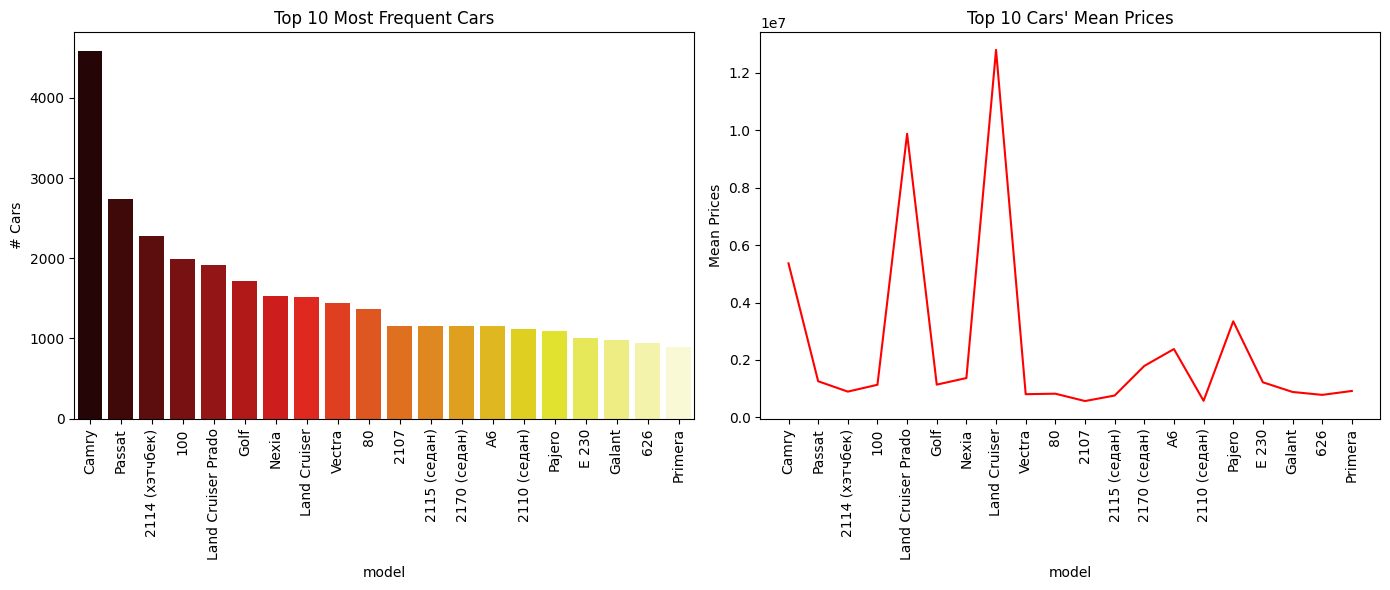

In [187]:
top20_cars = df['model'].value_counts().sort_values(ascending=False)[:20]
top20_mean_prices = [df[df['model'] == i]['price'].mean() for i in list(top20_cars.index)]

fig = plt.figure(figsize=(14, 6))

# Subplot 1 - Barplot for the number of cars
ax = fig.add_subplot(121)
sns.barplot(x=top20_cars.index, y=top20_cars.values, palette='hot', ax=ax)
plt.xticks(rotation=90)
plt.ylabel('# Cars')
plt.title('Top 10 Most Frequent Cars')

# Subplot 2 - Lineplot for mean prices
ax2 = fig.add_subplot(122)
sns.lineplot(x=top20_cars.index, y=top20_mean_prices, color='r', ax=ax2)
plt.xticks(rotation=90)
plt.ylabel('Mean Prices')
plt.title("Top 10 Cars' Mean Prices")

plt.tight_layout()
plt.show()

Кардинальность моделей очень большая. Убираем этот признак.

In [131]:
# Вывод количества уникальных категорий для каждой категориальной переменной
for column in new_categorical_columns:
    unique_categories = new_df[column].nunique()
    print(f'Кардинальность столбца {column}: {unique_categories}')

Кардинальность столбца brand: 121
Кардинальность столбца model: 1633
Кардинальность столбца Коробка передач: 6
Кардинальность столбца Кузов: 15
Кардинальность столбца colour: 21
Кардинальность столбца fuel: 6
Кардинальность столбца wheel_drive: 3


In [21]:
# Применяем LabelEncoder к столбцам brand, colour и Кузов
label_encoder = LabelEncoder()
new_df['brand'] = label_encoder.fit_transform(new_df['brand'])
new_df['Кузов'] = label_encoder.fit_transform(new_df['Кузов'])
new_df['colour'] = label_encoder.fit_transform(new_df['colour'])
new_df['model'] = label_encoder.fit_transform(new_df['model'])

# Применяем OneHotEncoder к столбцам "Коробка передач" и "fuel"
onehot_encoder = OneHotEncoder(sparse=False, drop='first')
onehot_encoded_data = onehot_encoder.fit_transform(new_df[['Коробка передач', 'fuel', 'wheel_drive']])

# Создаем новые DataFrame с one-hot закодированными значениями
df_encoded = pd.DataFrame(
    onehot_encoded_data,
    columns=onehot_encoder.get_feature_names_out(['Коробка передач', 'fuel', 'wheel_drive'])
)

# Удаляем исходные столбцы
new_df.drop(['Коробка передач', 'fuel', 'wheel_drive'], axis=1, inplace=True)

# Объединяем новые закодированные столбцы
new_df = pd.concat([new_df, df_encoded], axis=1)

C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [160]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108342 entries, 0 to 108438
Data columns (total 98 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   brand                        108342 non-null  float64
 1   model                        108342 non-null  float64
 2   price                        108342 non-null  float64
 3   year                         108342 non-null  float64
 4   Кузов                        108342 non-null  float64
 5   engine volume                108342 non-null  float64
 6   log_mileage                  108342 non-null  float64
 7   customs_clearance            108342 non-null  float64
 8   left_hand_drive              108342 non-null  float64
 9   Order                        108342 non-null  float64
 10  metallic                     108342 non-null  float64
 11  colour                       108342 non-null  float64
 12  Литые диски                  108342 non-null  float64
 13  Тони

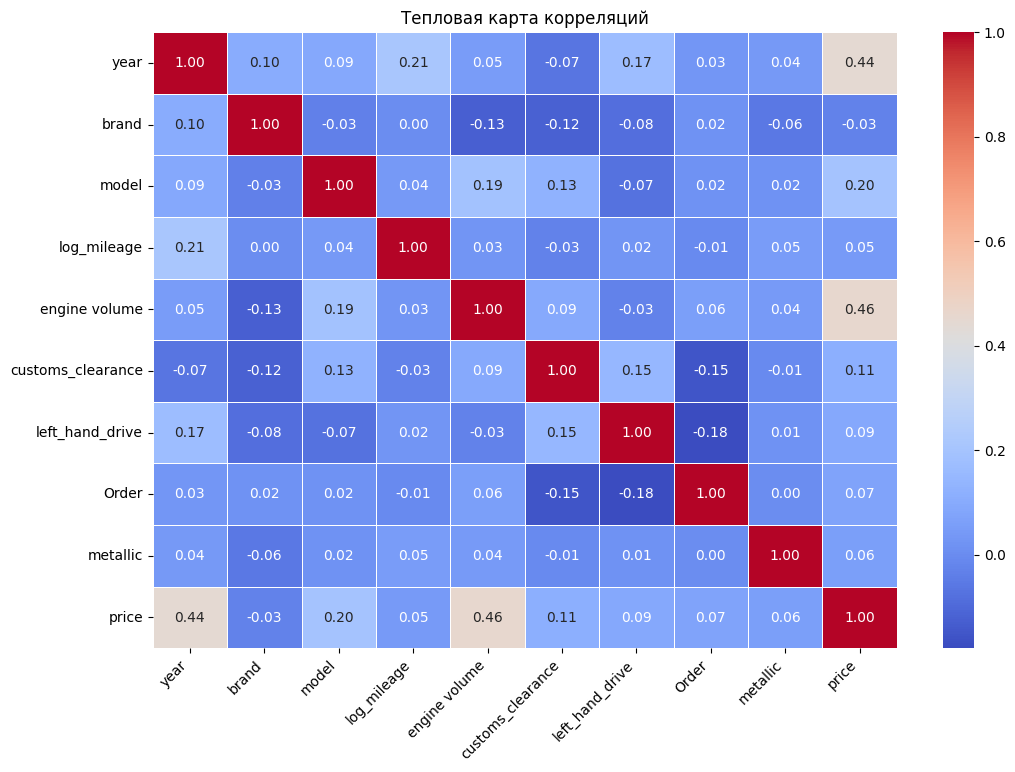

In [163]:
# Создание тепловой карты корреляций
correlation_matrix = new_df[['year', 'brand','model', 'log_mileage','engine volume','customs_clearance','left_hand_drive','Order','metallic', 'price']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.xticks(rotation=45, ha='right')
plt.title('Тепловая карта корреляций')
plt.show()

In [22]:
del_columns = ['description']

new_df.drop(del_columns, axis=1, inplace=True)

In [29]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108536 entries, 0 to 108232
Data columns (total 98 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   brand                        108439 non-null  float64
 1   model                        108439 non-null  float64
 2   price                        108439 non-null  float64
 3   year                         108439 non-null  float64
 4   Кузов                        108439 non-null  float64
 5   engine volume                108439 non-null  float64
 6   log_mileage                  108439 non-null  float64
 7   customs_clearance            108439 non-null  float64
 8   left_hand_drive              108439 non-null  float64
 9   Order                        108439 non-null  float64
 10  metallic                     108439 non-null  float64
 11  colour                       108439 non-null  float64
 12  Литые диски                  108439 non-null  float64
 13  Тони

In [30]:
new_df = new_df.dropna()

In [31]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108342 entries, 0 to 108438
Data columns (total 98 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   brand                        108342 non-null  float64
 1   model                        108342 non-null  float64
 2   price                        108342 non-null  float64
 3   year                         108342 non-null  float64
 4   Кузов                        108342 non-null  float64
 5   engine volume                108342 non-null  float64
 6   log_mileage                  108342 non-null  float64
 7   customs_clearance            108342 non-null  float64
 8   left_hand_drive              108342 non-null  float64
 9   Order                        108342 non-null  float64
 10  metallic                     108342 non-null  float64
 11  colour                       108342 non-null  float64
 12  Литые диски                  108342 non-null  float64
 13  Тони

### Модель

In [32]:
# Подготовка данных
X = new_df.drop('price', axis=1)  # Входные признаки (все столбцы, кроме 'price')
y = new_df['price']  # Целевая переменная

In [33]:
# Разбиваем данные на train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
X_train.shape, X_test.shape

((86673, 97), (21669, 97))

In [168]:
X_train

array([[-0.15248112, -0.23721881, -0.5956224 , ..., -0.01593399,
        -1.20374933,  1.77242351],
       [ 1.02525496, -1.36263136,  0.1858294 , ..., -0.01593399,
        -1.20374933, -0.56419924],
       [-0.43141862,  0.15887611, -0.03744254, ..., -0.01593399,
        -1.20374933, -0.56419924],
       ...,
       [ 1.02525496, -1.37101432, -0.37235046, ..., -0.01593399,
         0.83073774, -0.56419924],
       [-0.9273075 ,  1.3848842 ,  0.74400925, ..., -0.01593399,
         0.83073774, -0.56419924],
       [-2.01206442, -1.08599364, -0.03744254, ..., -0.01593399,
         0.83073774, -0.56419924]])

In [174]:
# Обучение модели линейной регрессии
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_test_pred_lr = lr_model.predict(X_test)
mae_lr_test = mean_absolute_error(y_test, y_test_pred_lr)
mse_lr_test = mean_squared_error(y_test, y_test_pred_lr)
r2_lr_test = r2_score(y_test, y_test_pred_lr)

print("Mean Squared Error (Linear Regression):", mse_lr_test)
print("Mean Absolute Error (Linear Regression):", mae_lr_test)
print("R-squared (Linear Regression):", r2_lr_test)

Mean Squared Error (Linear Regression): 16194461933334.412
Mean Absolute Error (Linear Regression): 1939926.8345470342
R-squared (Linear Regression): 0.46496211457385894


In [172]:
# Инициализация и обучение модели дерева решений
dt_model = DecisionTreeRegressor()

dt_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [175]:
y_pred_dt = dt_model.predict(X_test_standard)

# Оценка качества модели
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# Вывод результатов
print("Mean Squared Error (Decision Tree):", mse_dt)
print("Mean Absolute Error (Decision Tree):", mae_dt)
print("R-squared (Decision Tree):", r2_dt)

Mean Squared Error (Decision Tree): 9801621581253.883
Mean Absolute Error (Decision Tree): 760418.6783807897
R-squared (Decision Tree): 0.6761708474063808


In [176]:
# Обучение модели случайного леса
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_test_pred_rf = rf_model.predict(X_test)
mae_rf_test = mean_absolute_error(y_test, y_test_pred_rf)
mse_rf_test = mean_squared_error(y_test, y_test_pred_rf)
r2_rf_test = r2_score(y_test, y_test_pred_rf)

print("Mean Squared Error (Random Forest):", mse_rf_test)
print("Mean Absolute Error (Random Forest):", mae_rf_test)
print("R-squared (Random Forest):", r2_rf_test)

Mean Squared Error (Random Forest): 3914374146837.596
Mean Absolute Error (Random Forest): 542537.3513515241
R-squared (Random Forest): 0.8706756374548147


In [55]:
# Подбор гиперпараметров для модели случайного леса с помощью Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=2)
rf_grid_search.fit(X_train, y_train)

# Лучшие найденные гиперпараметры для случайного леса
best_rf_params = rf_grid_search.best_params_

In [56]:
best_rf_params

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [182]:
# Обучение модели случайного леса с лучшими гиперпараметрами
rf_model_best = RandomForestRegressor(random_state=42, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
rf_model_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=200, random_state=42)

In [183]:
# Оценка модели случайного леса с лучшими гиперпараметрами на тестовом наборе данных
y_pred_rf_best = rf_model_best.predict(X_test)

mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)

print("Mean Squared Error (Random Forest - Test with Best Params):", mse_rf_best)
print("Mean Absolute Error (Random Forest - Test with Best Params):", mae_rf_best)
print("R-squared (Random Forest - Test with Best Params):", r2_rf_best)

Mean Squared Error (Random Forest - Test with Best Params): 3842631410103.8706
Mean Absolute Error (Random Forest - Test with Best Params): 538740.1130907554
R-squared (Random Forest - Test with Best Params): 0.8730458972581172


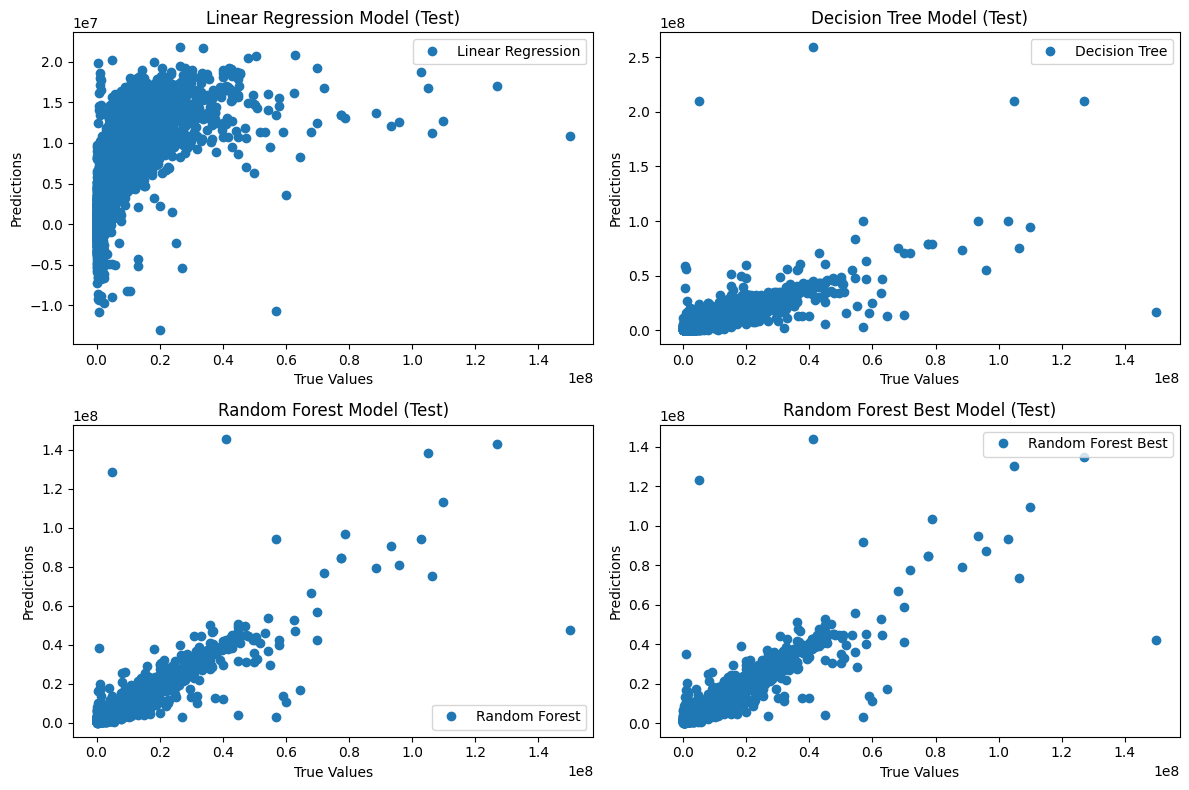

In [184]:
# Построение графиков качества оценки моделей
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(y_test, y_test_pred_lr, 'o', label='Linear Regression')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear Regression Model (Test)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test, y_pred_dt, 'o', label='Decision Tree')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Decision Tree Model (Test)')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test, y_test_pred_rf, 'o', label='Random Forest')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Random Forest Model (Test)')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test, y_pred_rf_best, 'o', label='Random Forest Best')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Random Forest Best Model (Test)')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
# Создание модели XGBoost
xgb_model = xgb.XGBRegressor(
    max_depth = 3,
    min_samples_leaf = 5,
    learning_rate=0.1,  # Уменьшаем скорость обучения
    n_estimators=1000,  # Большое количество итераций
    early_stopping_rounds=10,  # Ранняя остановка после 10 итераций без улучшений
    gamma=0.1,  # Параметр регуляризации
    random_state=42
)

# Обучение модели с сохранением истории ошибок
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, eval_metric=["mae", "rmse"], verbose=False)

# История ошибок на обучающем и тестовом наборах
train_errors_xgb = xgb_model.evals_result()["validation_0"]["rmse"]
test_errors_xgb = xgb_model.evals_result()["validation_1"]["rmse"]


C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [00:14:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


In [54]:
# Предсказание на тестовом наборе данных
y_test_pred_xgb = xgb_model.predict(X_test)

# Оценка производительности модели
mae_xgb_test = mean_absolute_error(y_test, y_test_pred_xgb)
mse_xgb_test = mean_squared_error(y_test, y_test_pred_xgb)
r2_xgb_test = r2_score(y_test, y_test_pred_xgb)

print("Mean Squared Error (XGBoost):", mse_xgb_test)
print("Mean Absolute Error (XGBoost):", mae_xgb_test)
print("R-squared (XGBoost):", r2_xgb_test)

Mean Squared Error (XGBoost): 3459404907976.3003
Mean Absolute Error (XGBoost): 695054.7857403442
R-squared (XGBoost): 0.8857070587206997


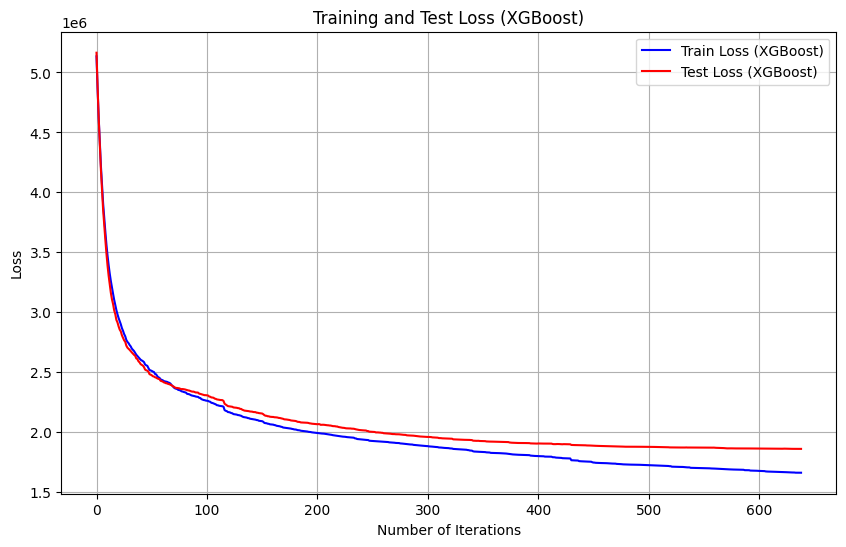

In [55]:
# График для XGBoost
plt.figure(figsize=(10, 6))
plt.plot(train_errors_xgb, label='Train Loss (XGBoost)', color='blue')
plt.plot(test_errors_xgb, label='Test Loss (XGBoost)', color='red')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Training and Test Loss (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
from catboost import CatBoostRegressor

# Обучение модели CatBoost
catboost_model = CatBoostRegressor(random_state=42, verbose=False)
catboost_model.fit(X_train, y_train)

# Предсказание на тестовом наборе данных
y_test_pred_catboost = catboost_model.predict(X_test)

# Оценка производительности модели
mae_catboost_test = mean_absolute_error(y_test, y_test_pred_catboost)
mse_catboost_test = mean_squared_error(y_test, y_test_pred_catboost)
r2_catboost_test = r2_score(y_test, y_test_pred_catboost)

print("Mean Squared Error (CatBoost):", mse_catboost_test)
print("Mean Absolute Error (CatBoost):", mae_catboost_test)
print("R-squared (CatBoost):", r2_catboost_test)


Mean Squared Error (CatBoost): 2994119577666.2856
Mean Absolute Error (CatBoost): 589983.5392745517
R-squared (CatBoost): 0.9010793063615089


In [42]:
# Создание модели CatBoost
catboost_model = CatBoostRegressor(random_state=42, verbose=False)

# Обучение модели с сохранением истории ошибок
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

# История ошибок на обучающем и тестовом наборах
train_errors_catboost = catboost_model.evals_result_["learn"]["RMSE"]
test_errors_catboost = catboost_model.evals_result_["validation"]["RMSE"]

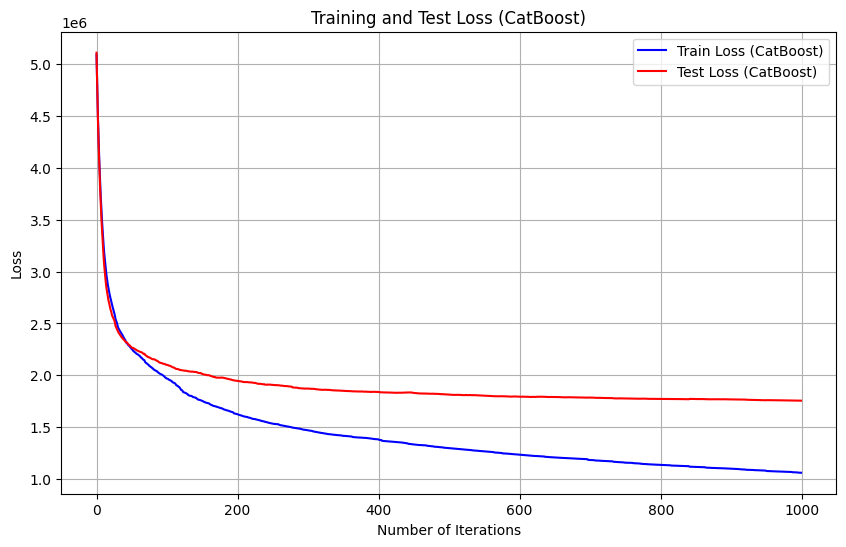

In [43]:
# График для CatBoost
plt.figure(figsize=(10, 6))
plt.plot(train_errors_catboost, label='Train Loss (CatBoost)', color='blue')
plt.plot(test_errors_catboost, label='Test Loss (CatBoost)', color='red')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Training and Test Loss (CatBoost)')
plt.legend()
plt.grid(True)
plt.show()

### Экономическая амортизация

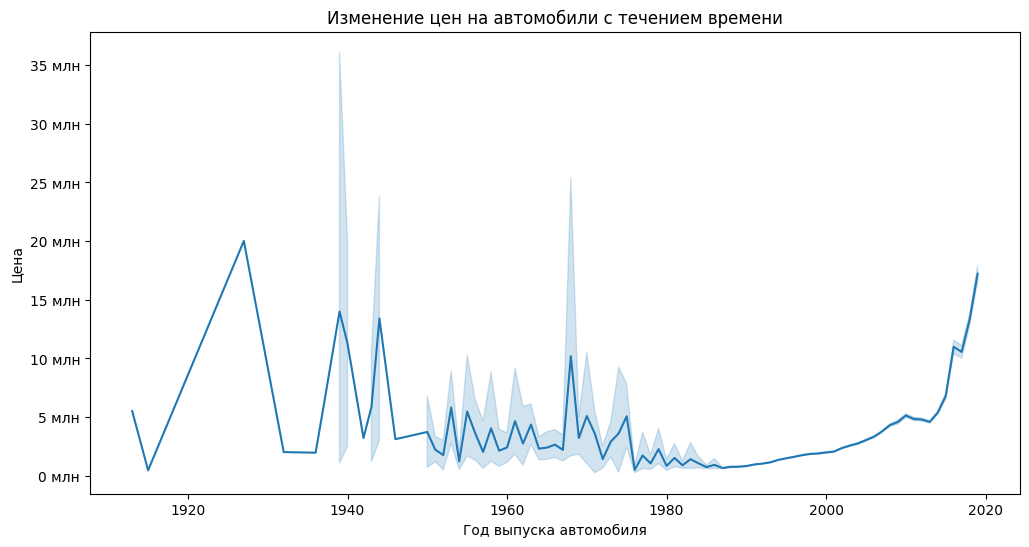

In [187]:
from matplotlib.ticker import FuncFormatter

# Визуализация изменения цен со временем для всех автомобилей
plt.figure(figsize=(12, 6))

sns.lineplot(x='year', y='price', data=df)
plt.title('Изменение цен на автомобили с течением времени')
plt.xlabel('Год выпуска автомобиля')
plt.ylabel('Цена')

# Настройка меток оси y для отображения в миллионах
formatter = FuncFormatter(lambda x, _: f'{int(x / 1e6)} млн')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


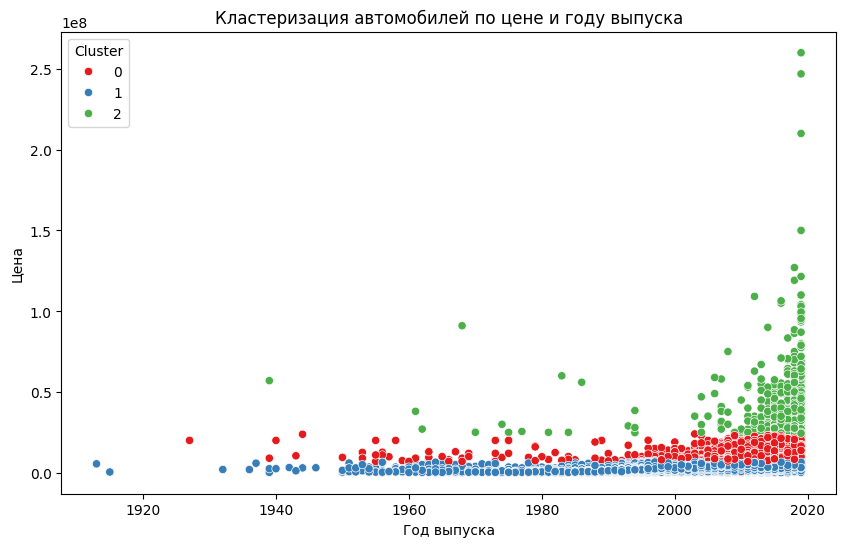

In [193]:
# Предположим, что мы хотим разделить автомобили на 3 кластера по цене и году выпуска
clusters_df = df.copy()
kmeans = KMeans(n_clusters=3)
clusters_df['Cluster'] = kmeans.fit_predict(clusters_df[['year', 'price']])

# 5. Визуализация результатов кластеризации
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='price', hue='Cluster', data=clusters_df, palette='Set1', legend='full')
plt.title('Кластеризация автомобилей по цене и году выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Цена')
plt.show()

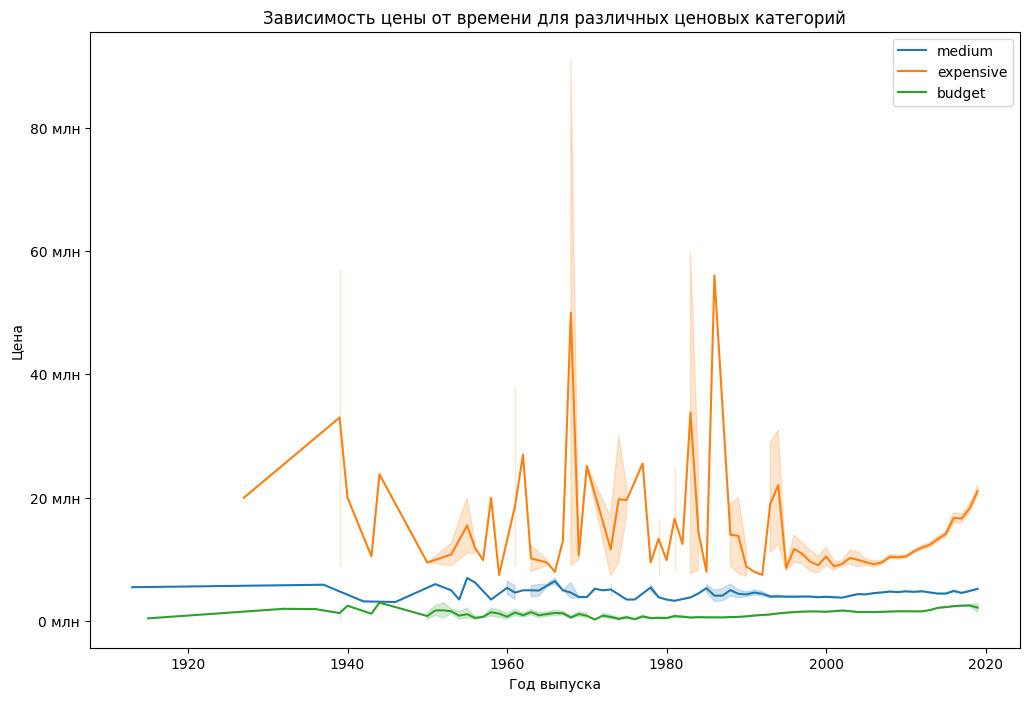

In [208]:
# 1. Кластеризация производителей по ценовым категориям
df_amortization = df.copy()

# Определение ценовых квантилей для разделения на кластеры
#low_price_quantile = df_amortization['price'].quantile(0.33)
#high_price_quantile = df_amortization['price'].quantile(0.66)

low_price = 3000000
high_price = 7000000

# Функция для определения ценовой категории
def price_category(price):
    if price <= low_price:
        return 'budget'
    elif price <= high_price:
        return 'medium'
    else:
        return 'expensive'

# Добавление столбца с категорией цен
df_amortization['price_category'] = df_amortization['price'].apply(price_category)

# 2. Анализ зависимости цены от времени для каждого кластера

plt.figure(figsize=(12, 8))

# Построение графиков для каждой ценовой категории
for category in df_amortization['price_category'].unique():
    sns.lineplot(x='year', y='price', data=df_amortization[df_amortization['price_category'] == category], label=category)

plt.title('Зависимость цены от времени для различных ценовых категорий')
plt.xlabel('Год выпуска')
plt.ylabel('Цена')
plt.legend()

# Настройка меток оси y для отображения в миллионах
formatter = FuncFormatter(lambda x, _: f'{int(x / 1e6)} млн')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

budget: Audi, BMW, Chery, Chevrolet, Chrysler, Daewoo, Dodge, FAW, Fiat, Ford, Geely, Honda, Isuzu, Jeep, Lifan, Lincoln, Mazda, Mercedes-Benz, Mitsubishi, Nissan, Opel, Peugeot, Subaru, Suzuki, Volkswagen, Volvo, ВАЗ (Lada), ГАЗ, ЗАЗ, ИЖ, Москвич, Ретро-автомобили, УАЗ
medium: Hummer, Hyundai, Infiniti, Iveco, JAC, Kia, Lexus, Porsche, Ravon, Renault, Skoda, SsangYong, Toyota
expensive: Bentley, Cadillac, Jaguar, Land Rover

***Бюджетные автомобили***: цены на бюджетные автомобили остаются относительно стабильными с течением времени, что может указывать на низкую склонность к амортизации. Это может быть связано с тем, что ценовая эластичность спроса на такие автомобили меньше, их спрос остается стабильным даже при изменениях в рыночных условиях.

***Средние автомобили***: более подвержены амортизации по сравнению с бюджетными моделями. Это может быть связано с более высокой конкуренцией в этом сегменте рынка, появлением новых моделей и технологий, что приводит к более частым изменениям цен.


***Дорогие автомобили***: Скачущий график для дорогих автомобилей может указывать на более значительные колебания цен во времени. Это может быть связано с различными факторами, такими как изменения в спросе и предложении на рынке, колебания в экономике или изменения в ценности или престиже конкретных моделей или брендов. Дорогие автомобили также могут подвергаться более высоким процентам амортизации из-за их высокой начальной стоимости, что приводит к более значительным изменениям в цене с течением времени.
